## APPLE Share Price Prediction Model at Different Timeframes
___

#### Summary of the problem and the approach chosen
This project aims to forecast the APPLE stock price at different time intervals. It is worth noting that forecasting has always been an issue in many fields: a call centre every week requires forecasts of call volumes, a weather forecast, a decision on whether to build another power station in the next five years requires forecasts of future demand, the management of a portfolio of equity investments requires forecasts of stock requirements.

For the implementation of the project was used a data set from the Kaggle. The programming language used is Python in the Jupyter Notebook environment. More specifically, an attempt was made to construct a prediction model based on a Long short-term memory (LSTM), which LSTM is an artificial neural network.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import matplotlib as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

from keras import layers
from keras import models

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

We begin our approach to the problem by getting a handle on our data set. We see how our data is structured and we think about how to manage it.

In [2]:
# Load the dataset
dataset = pd.read_csv('AAPL.csv')
dataset

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.0500,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.1000,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.9000,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.0500,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.3200,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.960,316.500,310.3241,313.17,33843125,314.960000,316.500000,310.324100,313.170000,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.140,318.520,313.0100,315.03,25432385,313.140000,318.520000,313.010000,315.030000,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.230,319.520,316.2000,316.68,27876215,319.230000,319.520000,316.200000,316.680000,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.850,320.890,315.8700,318.66,25672211,316.850000,320.890000,315.870000,318.660000,25672211,0.0,1.0


We check if there are any lost values in our data set and if there are, we discard the rows containing them.

In [3]:
print(dataset.isnull().sum())
total_null = dataset.isnull().sum().sum()
print("The total number of null values is: " + str(total_null))

Unnamed: 0     0
symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64
The total number of null values is: 0


We check the type of our data

In [4]:
print(dataset.dtypes)

Unnamed: 0       int64
symbol          object
date            object
close          float64
high           float64
low            float64
open           float64
volume           int64
adjClose       float64
adjHigh        float64
adjLow         float64
adjOpen        float64
adjVolume        int64
divCash        float64
splitFactor    float64
dtype: object


We format the type of the date variable, as we will then use it as an index in our graphical representation.

In [5]:
dataset["date"] = pd.to_datetime(dataset.date, format="%Y/%m/%d")
dataset.dtypes

Unnamed: 0                   int64
symbol                      object
date           datetime64[ns, UTC]
close                      float64
high                       float64
low                        float64
open                       float64
volume                       int64
adjClose                   float64
adjHigh                    float64
adjLow                     float64
adjOpen                    float64
adjVolume                    int64
divCash                    float64
splitFactor                float64
dtype: object

Of all the variables in the data set we keep only the variable open, because our model will be based on it.

In [6]:
dataset.index = dataset['date']
dataset.drop(['Unnamed: 0', 'symbol', 'date', 'close', 'high', 'low', 'volume', 'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor'], axis=1, inplace=True)


In [7]:
print(dataset)
print(dataset.shape)

                             open
date                             
2015-05-27 00:00:00+00:00  130.34
2015-05-28 00:00:00+00:00  131.86
2015-05-29 00:00:00+00:00  131.23
2015-06-01 00:00:00+00:00  131.20
2015-06-02 00:00:00+00:00  129.86
...                           ...
2020-05-18 00:00:00+00:00  313.17
2020-05-19 00:00:00+00:00  315.03
2020-05-20 00:00:00+00:00  316.68
2020-05-21 00:00:00+00:00  318.66
2020-05-22 00:00:00+00:00  315.77

[1258 rows x 1 columns]
(1258, 1)


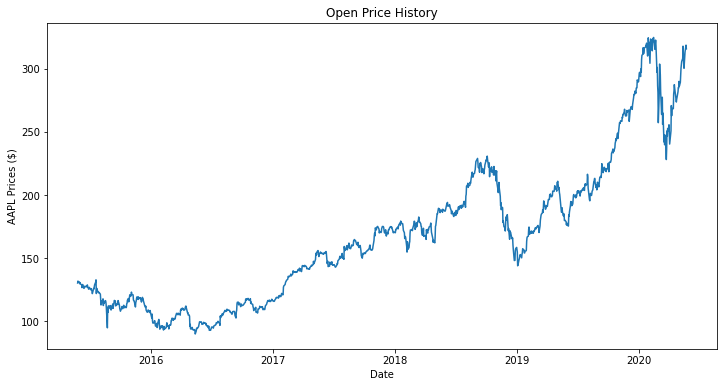

In [8]:
plt.figure(figsize = (12,6))
plt.plot(dataset["open"])
plt.title('Open Price History')
plt.xlabel("Date")
plt.ylabel("AAPL Prices ($)")
plt.show()

We convert our data into numpy format. This is because, we want to turn our data set into an 2D table.

In [9]:
train_data = dataset.to_numpy()
train_data

array([[130.34],
       [131.86],
       [131.23],
       ...,
       [316.68],
       [318.66],
       [315.77]])

We divide our data set into train set and test set. More specifically, we take 70% of the data as the train set and the remaining 30% as the test set.

In [10]:
dataset_train = np.array(train_data[:int(train_data.shape[0]*0.7)]) 
dataset_test = np.array(train_data[int(train_data.shape[0]*0.7):])

print("The shape of the training set is: ", dataset_train.shape)
print("The shape of the testing set is: ", dataset_test.shape)

The shape of the training set is:  (880, 1)
The shape of the testing set is:  (378, 1)


Normalisation of our data.

In [11]:
scalar = MinMaxScaler(feature_range = (0,1))
train_data = scalar.fit_transform(train_data)
train_data.shape

(1258, 1)

I declare x_train and y_train. We also convert x_train to a 3D input, because only then will it be accepted in our LSTM model.

In [12]:
x_train = train_data[0:1257]
y_train = train_data[1:1258]

x_train = np.reshape(x_train, (1257,1,1))
x_train.shape

(1257, 1, 1)

We create the LSTM model. First, create the pre-trained Sequential model that allows us to add layers.

The LSTM level defines the number of units denoting the dimension of the output space. Return_sequences = True specifies whether to return the previous output in the output sequence or the full sequence. The input_shape indicates the shape of the training set and reflects the number of time steps, while the last parameter is the number of markers.

The Dropout layer randomly selects neurons and ignores them to make our network less sensitive to specific neuron values for better generalization. This avoids overfitting, which describes the phenomenon that models perform better on training data than on test data.

In [13]:
model = Sequential()
model.add(LSTM(units = 96, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 96))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 96)             37632     
                                                                 
 dropout (Dropout)           (None, 1, 96)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 96)             74112     
                                                                 
 dropout_1 (Dropout)         (None, 1, 96)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 96)             74112     
                                                                 
 dropout_2 (Dropout)         (None, 1, 96)             0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

Next, we add the information about the fit algorithm. The loss function that is minimized is mean_squared_error. The adam method is used as an optimizer. This process is done through the compile method.

In [14]:
model.compile(optimizer = 'adam', loss = "mean_squared_error")

We start training the neural network. This is achieved through the fit method. In the first two parameters of this method, the training data (x_train and y_train) are entered, followed by the epochs and batch size parameters. The parameter epochs, refers to the number of epochs, where one epoch corresponds to one pass of all training data through the neural network. In this paper, 100 seasons are used. The parameter batch_size refers to the size of the observation set, this means that in each iteration, the optimization algorithm randomly selects a set of observations with an abundance equal to the value of the parameter to calculate the derivative. In this paper we will use an observation group size equal to 32.

In [15]:
modelo = model.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
40/40 [==============================] - 15s 14ms/step - loss: 0.0943
Epoch 2/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0234
Epoch 3/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 4/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0025
Epoch 5/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0022
Epoch 6/100
40/40 [==============================] - 1s 12ms/step - loss: 0.0019
Epoch 7/100
40/40 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 8/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0013
Epoch 9/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 10/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 11/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 12/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 13/100
40/40 [====

We create a graph for the loss function, in order to see its path.

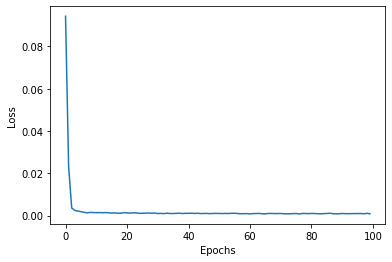

In [16]:
plt.plot(modelo.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

We note that the graph is the desired path, as it is decreasing and tends to 0.

In [17]:
print(dataset_test)
print(dataset_test.shape)

[[178.37  ]
 [179.73  ]
 [174.94  ]
 [174.24  ]
 [171.51  ]
 [176.73  ]
 [182.66  ]
 [180.29  ]
 [184.46  ]
 [180.95  ]
 [171.76  ]
 [173.49  ]
 [165.    ]
 [171.66  ]
 [170.4   ]
 [170.49  ]
 [169.    ]
 [165.45  ]
 [165.38  ]
 [166.    ]
 [160.4   ]
 [156.86  ]
 [148.15  ]
 [148.3   ]
 [155.84  ]
 [157.5   ]
 [158.53  ]
 [154.89  ]
 [143.98  ]
 [144.53  ]
 [148.7   ]
 [149.56  ]
 [151.29  ]
 [152.5   ]
 [152.88  ]
 [150.85  ]
 [150.27  ]
 [153.08  ]
 [154.2   ]
 [157.5   ]
 [156.41  ]
 [154.15  ]
 [154.11  ]
 [155.48  ]
 [155.79  ]
 [156.25  ]
 [163.25  ]
 [166.11  ]
 [166.96  ]
 [167.41  ]
 [172.86  ]
 [174.65  ]
 [172.4   ]
 [168.99  ]
 [171.05  ]
 [170.1   ]
 [171.39  ]
 [169.71  ]
 [171.25  ]
 [169.71  ]
 [171.19  ]
 [171.8   ]
 [171.58  ]
 [174.16  ]
 [173.71  ]
 [173.21  ]
 [174.32  ]
 [174.28  ]
 [175.69  ]
 [175.94  ]
 [174.67  ]
 [173.87  ]
 [170.32  ]
 [175.49  ]
 [180.    ]
 [182.25  ]
 [183.9   ]
 [184.85  ]
 [185.8   ]
 [188.35  ]
 [186.23  ]
 [190.02  ]
 [195.34  ]
 [19

In [18]:
inputs = np.reshape(scalar.transform(dataset_test), (378,1,1))
stock_prediction = scalar.inverse_transform(model.predict(inputs))
print(stock_prediction)
print(stock_prediction.shape)

12/12 [==============================] - 4s 7ms/step
[[175.3988 ]
 [176.77368]
 [171.94118]
 [171.23737]
 [168.49876]
 [173.74379]
 [179.74275]
 [177.34042]
 [181.57117]
 [178.00882]
 [168.74913]
 [170.48401]
 [162.01161]
 [168.64897]
 [167.38823]
 [167.47821]
 [165.99007]
 [162.45795]
 [162.38849]
 [163.0039 ]
 [157.46802]
 [153.99606]
 [145.55219]
 [145.69637]
 [152.99982]
 [154.6221 ]
 [155.63121]
 [152.07367]
 [141.56264]
 [142.0868 ]
 [146.08104]
 [146.90915]
 [148.57945]
 [149.75114]
 [150.11969]
 [148.15408]
 [147.59393]
 [150.31377]
 [151.40205]
 [154.6221 ]
 [153.55632]
 [151.35341]
 [151.31451]
 [152.64868]
 [152.95103]
 [153.40004]
 [160.27895]
 [163.11314]
 [163.95798]
 [164.40569]
 [169.85176]
 [171.64952]
 [169.39046]
 [165.9801 ]
 [168.03835]
 [167.08838]
 [168.37863]
 [166.69879]
 [168.2385 ]
 [166.69879]
 [168.17844]
 [168.7892 ]
 [168.56886]
 [171.15697]
 [170.70491]
 [170.20294]
 [171.31778]
 [171.27756]
 [172.69597]
 [172.94772]
 [171.66963]
 [170.86562]
 [167.30826

We create a joint graph for the two variables above, so that we can see graphically how close our model has come.

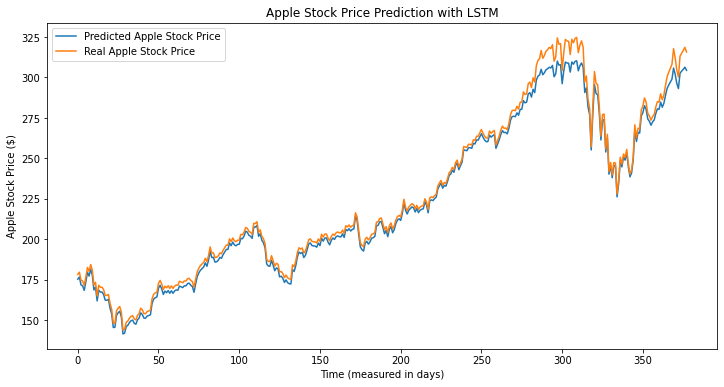

In [19]:
plt.figure(figsize = (12,6))
plt.plot(stock_prediction, label = "Predicted Apple Stock Price", linewidth = 1.5)
plt.plot(dataset_test, label = "Real Apple Stock Price", linewidth = 1.5)
plt.title("Apple Stock Price Prediction with LSTM")
plt.xlabel("Time (measured in days)")
plt.ylabel("Apple Stock Price ($)")
plt.legend()
plt.show()

Last but not least, we calculate the mean absolute error between the predictions and the actual value, in order to evaluate our model.

In [20]:
import sklearn.metrics
test_mae_nn = sklearn.metrics.mean_absolute_error(dataset_test, stock_prediction.squeeze())
print("The Mean Absolute Error of the Test Data is", test_mae_nn)

The Mean Absolute Error of the Test Data is 3.751692593044705


We see that the average absolute error, calculated on the basis of our model, is about 2.23. So the predictive ability of our model is quite strong.